In [359]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.utils import shuffle

In [360]:
# Load train, test, and validation datasets
train_path = '../APP-1/train.csv'
test_path = '../APP-1/test.csv'
val_path = '../APP-1/val_without_labels.csv'

train_data = pd.read_csv('../APP-1/train.csv')
test_data = pd.read_csv('../APP-1/test.csv')
validation_data = pd.read_csv('../APP-1/val_without_labels.csv')

In [361]:
# # Shuffle train and test datasets, RandomForest accuracy is going down after shuffle
# train_data = shuffle(train_data, random_state=42)
# test_data = shuffle(test_data, random_state=42)

In [362]:
# X_train = train_data.iloc[:, :-1]
# y_train = train_data.iloc[:,-1]

# X_test = test_data.iloc[:, :-1]
# y_test = test_data.iloc[:,-1]

In [363]:
#X_train
#y_train

In [364]:
# train_data.hist(figsize=(50, 50), bins=20)
# plt.show()

In [415]:
def preprocess_data(data, is_training=True, label_encoder=None):
    # Encode label column if in training or testing
    if is_training and 'label' in data.columns:
        data['label'] = label_encoder.fit_transform(data['label'])
    elif 'label' in data.columns:
        data['label'] = label_encoder.transform(data['label'])

In [416]:
# Initialize label encoder
le_label = LabelEncoder()

Preprocess train and test datasets
train_cleaned = preprocess_data(train_data, is_training=True, label_encoder=le_label)
test_cleaned = preprocess_data(test_data, is_training=True, label_encoder=le_label)

SyntaxError: invalid syntax (426073225.py, line 4)

In [366]:
non_numeric_cols = train_data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

non_numeric_cols_test = test_data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: Index(['Source_IP', 'Destination_IP', 'Protocol', 'label'], dtype='object')
Non-numeric columns: Index(['Source_IP', 'Destination_IP', 'Protocol', 'label'], dtype='object')


In [390]:
def is_numeric_name(non_numeric_cols, data_set):
    for col in non_numeric_cols:
        try:
            data_set[col] = data_set[col].astype(float)
        except ValueError:
            print(f"Column '{col}' contains non-numeric values and cannot be converted.")
# # Dictionary to store mappings for each column
# category_mappings = {}

# def convert_to_numeric(non_numeric_cols, data_set):
#     global category_mappings  # To store mappings persistently
#     for col in non_numeric_cols:
#         data_set[col] = data_set[col].astype('category')
#         category_mappings[col] = data_set[col].cat.categories
#         data_set[col] = data_set[col].cat.codes

# def revert_to_original(non_numeric_cols, data_set):
#     global category_mappings
#     for col in non_numeric_cols:
#         if col in category_mappings:
#             data_set[col] = pd.Categorical.from_codes(
#                 data_set[col], categories=category_mappings[col]
#             )

In [391]:
is_numeric_name(non_numeric_cols, train_data)

In [392]:
is_numeric_name(non_numeric_cols_test, test_data)

In [393]:
def convert_to_numeric(non_numeric_cols, data_set):
    for col in non_numeric_cols:
        data_set[col] = data_set[col].astype('category').cat.codes

In [394]:
convert_to_numeric(non_numeric_cols, train_data)
convert_to_numeric(non_numeric_cols_test, test_data)

In [395]:
# Compute correlation matrix
correlation_matrix = train_data.corr()
# print(correlation_matrix)

In [373]:
num_features = correlation_matrix.shape[0]
plt.figure(figsize=(num_features * 1.2, num_features))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [396]:
# Function to remove highly correlated features
def remove_highly_correlated_features(data, threshold=0.8):
    # Compute correlation matrix
    correlation_matrix = data.corr()

    # Select the upper triangle of the correlation matrix
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )

    # Find features with correlation greater than the threshold
    high_correlation_pairs = [
        (column, row)
        for column in upper_triangle.columns
        for row in upper_triangle.index
        if abs(upper_triangle.at[row, column]) >= threshold
    ]

    print("Highly correlated feature pairs:", high_correlation_pairs)

    # Find columns to drop
    to_drop = [
        column for column in upper_triangle.columns
        if any(abs(upper_triangle[column]) > threshold)
    ]

    # # Drop the identified columns from the DataFrame
    # reduced_data = data.drop(columns=to_drop)

    # print(f"Reduced DataFrame shape: {reduced_data.shape}")
    return to_drop

In [397]:
col_to_remove = remove_highly_correlated_features(train_data)

Highly correlated feature pairs: [('bwd_packets_amount', 'fwd_packets_amount'), ('fwd_packets_length', 'fwd_packets_amount'), ('fwd_packets_length', 'bwd_packets_amount'), ('bwd_packets_length', 'fwd_packets_amount'), ('bwd_packets_length', 'bwd_packets_amount'), ('bwd_packets_length', 'fwd_packets_length'), ('silence_windows', 'PSH_count'), ('max_bwd_inter_arrival_time', 'max_fwd_inter_arrival_time'), ('max_bib_inter_arrival_time', 'max_fwd_inter_arrival_time'), ('max_bib_inter_arrival_time', 'max_bwd_inter_arrival_time'), ('mean_bib_inter_arrival_time', 'mean_fwd_inter_arrival_time'), ('mean_bib_inter_arrival_time', 'mean_bwd_inter_arrival_time'), ('first_packet_sizes_0', 'Protocol'), ('first_packet_sizes_1', 'Protocol'), ('first_packet_sizes_1', 'first_packet_sizes_0'), ('min_packet_size', 'min_fwd_packet'), ('STD_delta_byte', 'STD_packet_size'), ('bandwidth_4', 'bandwidth_2'), ('bandwidth_5', 'bandwidth_3'), ('bandwidth_7', 'bandwidth_5'), ('bandwidth_9', 'bandwidth_5'), ('bandwidt

In [398]:
train_cleaned = train_data.drop(columns = col_to_remove)

In [399]:
# train_cleaned

In [400]:
test_cleaned = test_data.drop(columns = col_to_remove)

In [401]:
# test_cleaned

In [402]:
columns_to_drop = ['beaconning_0','beaconning_1','beaconning_2','beaconning_5',	'beaconning_6'	,'beaconning_7',	'beaconning_8',	'beaconning_9',	'beaconning_10','beaconning_11','beaconning_12','beaconning_13','beaconning_14','beaconning_15','beaconning_16','beaconning_17','beaconning_18','beaconning_19']
# ,'beaconning_3',	'beaconning_4'
train_cleaned2 = train_cleaned.drop(columns = columns_to_drop)
test_cleaned2 = test_cleaned.drop(columns = columns_to_drop)


In [403]:
X_train = train_cleaned2.iloc[:, :-1]
y_train = train_cleaned2.iloc[:,-1]

X_test = test_cleaned2.iloc[:, :-1]
y_test = test_cleaned2.iloc[:,-1]

In [404]:
# X_train

In [405]:
# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [406]:
# 3. Model Training
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_clf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [407]:
# Evaluate on test data
y_pred_test = rf_clf.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Random Forest Accuracy on Test Dataset: {accuracy_test:.2f}")
print("Random Forest Accuracy on Test Dataset: {0:.2f}%".format(accuracy_test*100))
print("Classification Report on Test Dataset:\n", classification_report(y_test, y_pred_test))
print("Confusion Matrix on Test Dataset:\n", confusion_matrix(y_test, y_pred_test))

Random Forest Accuracy on Test Dataset: 0.62
Random Forest Accuracy on Test Dataset: 61.56%
Classification Report on Test Dataset:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.50      0.40      0.44         5
           2       0.75      0.60      0.67         5
           3       0.75      0.60      0.67         5
           4       0.80      0.80      0.80         5
           5       1.00      1.00      1.00         5
           6       1.00      0.60      0.75         5
           7       0.62      1.00      0.77         5
           8       0.67      0.80      0.73         5
           9       0.33      0.60      0.43         5
          10       1.00      0.80      0.89         5
          11       0.57      0.80      0.67         5
          12       0.33      0.20      0.25         5
          13       0.80      0.80      0.80         5
          14       0.00      0.00      0.00         5
   

In [408]:
# # Initialize list to track performance
# performance_metrics = []

# # Number of iterations for the feedback loop
# num_iterations = 3

# for iteration in range(num_iterations):
#     print(f"\n=== Iteration {iteration + 1} ===")
    
#     # Train RandomForestClassifier with class weights
#     rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
#     rf_clf.fit(X_train_scaled, y_train)

#     # Evaluate on test data
#     y_pred_test = rf_clf.predict(X_test_scaled)
#     accuracy_test = accuracy_score(y_test, y_pred_test)
#     print(f"Random Forest Accuracy on Test Dataset (Iteration {iteration + 1}): {accuracy_test:.2f}")
#     performance_metrics.append(accuracy_test)

#     # Identify misclassified samples
#     misclassified_indices = np.where(y_pred_test != y_test)[0]
#     print(f"Number of misclassified samples: {len(misclassified_indices)}")
    
#     # If there are no misclassified samples, stop early
#     if len(misclassified_indices) == 0:
#         print("All samples correctly classified. Stopping early.")
#         break

#     # Adjust training data (optional: oversample or reweight)
#     misclassified_X = X_test_scaled[misclassified_indices]
#     misclassified_y = y_test.iloc[misclassified_indices]
    
#     # Combine misclassified test samples with training data
#     X_train_scaled = np.vstack((X_train_scaled, misclassified_X))
#     y_train = pd.concat([y_train, misclassified_y])

#     print(f"Training data expanded. New training size: {len(y_train)}")

# # Final evaluation on the original test set
# print("\n=== Final Evaluation ===")
# y_pred_final = rf_clf.predict(X_test_scaled)
# final_accuracy = accuracy_score(y_test, y_pred_final)
# print(f"Final Random Forest Accuracy: {final_accuracy:.2f}")
# print("Classification Report:\n", classification_report(y_test, y_pred_final, zero_division=0))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_final))

# # Plot performance over iterations
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, len(performance_metrics) + 1), performance_metrics, marker='o')
# plt.title("Model Performance Over Iterations")
# plt.xlabel("Iteration")
# plt.ylabel("Accuracy")
# plt.grid()
# plt.show()


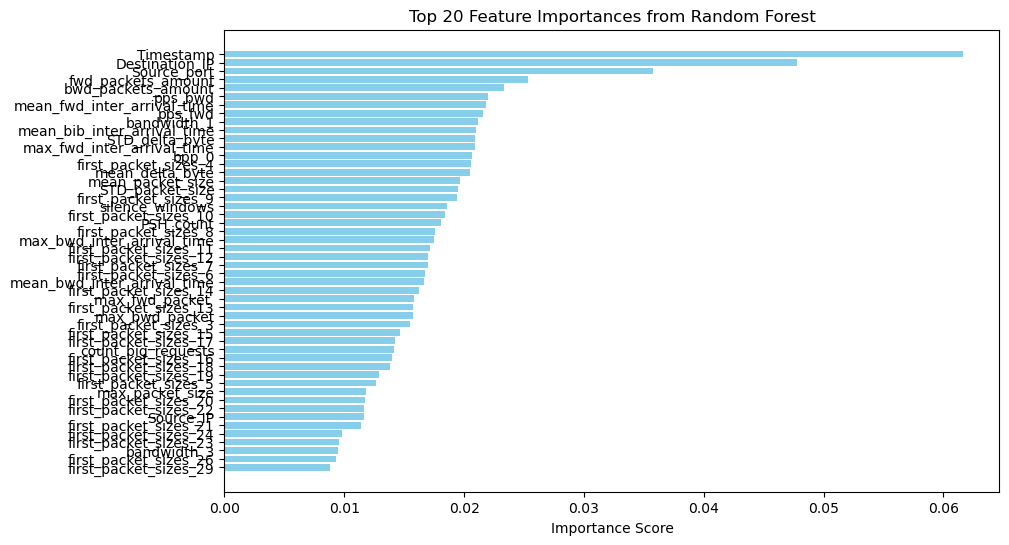

In [409]:
# Plot Feature Importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_df.head(50)  # Top 10 features
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 20 Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [355]:
# 4. Hyperparameter Tuning with RandomizedSearchCV
# This train can take 5 minutes
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

randomized_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_distributions=param_dist,
    n_iter=50,  # Test 50 random combinations
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)
randomized_search.fit(X_train_scaled, y_train)
print("Best Parameters from RandomizedSearchCV:", randomized_search.best_params_)

Best Parameters from RandomizedSearchCV: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': False}


In [356]:
# Train Random Forest with best parameters
rf_best_clf = randomized_search.best_estimator_
y_pred_best = rf_best_clf.predict(X_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Optimized Random Forest Accuracy on Test Dataset: {accuracy_best:.2f}")
print("Optimized Random Forest Accuracy on Test Dataset: {0:.2f}%".format(accuracy_best*100))

Optimized Random Forest Accuracy on Test Dataset: 0.65
Optimized Random Forest Accuracy on Test Dataset: 64.84%


In [410]:
# Train XGBoost Classifier
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_clf.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_clf.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy on Test Dataset: {accuracy_xgb:.2f}")
print("XGBoost Accuracy on Test Dataset (Origin Train Data): {0:.2f}%".format(accuracy_xgb*100))

XGBoost Accuracy on Test Dataset: 0.60
XGBoost Accuracy on Test Dataset (Origin Train Data): 60.00%


In [411]:
# Summary Results
print("\nSummary Results:")
print(f"Initial Random Forest Accuracy: {accuracy_test:.2f}")
print(f"Optimized Random Forest Accuracy: {accuracy_best:.2f}")
print(f"XGBoost Accuracy: {accuracy_xgb:.2f}")


Summary Results:
Initial Random Forest Accuracy: 0.62
Optimized Random Forest Accuracy: 0.65
XGBoost Accuracy: 0.60


In [389]:
# Add Predictions to Test Data
# test_data['RandomForest_Prediction'] = le_label.inverse_transform(y_pred_best)
# test_data['XGBoost_Prediction'] = le_label.inverse_transform(y_pred_xgb)

# # Save updated test data
# test_data.to_csv(test_path, index=False)
# print("Test predictions with Random Forest and XGBoost saved.")

NotFittedError: This LabelEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# # 5. Validation Predictions
# validation_cleaned = preprocess_data(validation_data, is_training=False, label_encoder=le_label)

# # Ensure feature alignment with training data
# missing_cols = set(X_train.columns) - set(validation_cleaned.columns)
# for col in missing_cols:
#     validation_cleaned[col] = 0
# validation_cleaned = validation_cleaned[X_train.columns]  # Align feature order

# # Standardize validation features
# validation_scaled = scaler.transform(validation_cleaned)

# # Predict on validation data using Random Forest
# validation_predictions_rf = rf_best_clf.predict(validation_scaled)
# validation_data['RandomForest_Prediction'] = le_label.inverse_transform(validation_predictions_rf)

# # Predict on validation data using XGBoost
# validation_predictions_xgb = xgb_clf.predict(validation_scaled)
# validation_data['XGBoost_Prediction'] = le_label.inverse_transform(validation_predictions_xgb)

In [ ]:
# # Save validation predictions
# validation_data.to_csv('../APP-1/val_without_labels.csv', index=False)
# print("Validation predictions with Random Forest and XGBoost saved.")